# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [ ]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [ ]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [ ]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - c2db5322


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Forrest_Gump.pdf to Forrest_Gump.pdf


In [ ]:
file_path = list(uploaded.keys())[0]
file_path

'Forrest_Gump.pdf'

We'll define our chunking strategy.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

retriever.invoke("Who was Forrest in love with?")

[Document(metadata={'source': 'source_72', 'file_path': 'Forrest_Gump.pdf', 'page': 48, 'total_pages': 147, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'pdfjs v2.4.7 (github.com/rkusa/pdfjs)', 'creationDate': "D:20240818073829-07'00'", 'modDate': '', 'trapped': '', '_id': '9c9ec86db8d9486cb1bf2f1317a74701', '_collection_name': 'pdf_to_parse_6a6b97b0-7690-443a-bac8-82f9820ba720'}, page_content='48.\nFORREST (V.O.)\nNighttime in the Army is a lovely\ntime.\nForrest lies in his bunk and looks up.\nFORREST (V.O.)\nWe\'d lay there in our bunks, and \nI\'d\nmiss my momma. And I\'d miss Jenny.\nA young private tosses a Playboy magazine onto Forrest.\nYOUNG PRIVATE\nHey, Gump. Get a load of the tits \non\nher!\nForrest pick up the magazine and turns the page, revealing\nJenny as she poses with a school sweater on, and that\'s all.\nThe pictorial is titled: "Girls of the South." Forrest looks\nup with shock. He cranes his head up for

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [ ]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [ ]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

In [ ]:
retriever.invoke("Who was Forrest in love with?")

[Document(metadata={'source': 'source_72', 'file_path': 'Forrest_Gump.pdf', 'page': 48, 'total_pages': 147, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'pdfjs v2.4.7 (github.com/rkusa/pdfjs)', 'creationDate': "D:20240818073829-07'00'", 'modDate': '', 'trapped': '', '_id': '9c9ec86db8d9486cb1bf2f1317a74701', '_collection_name': 'pdf_to_parse_6a6b97b0-7690-443a-bac8-82f9820ba720'}, page_content='48.\nFORREST (V.O.)\nNighttime in the Army is a lovely\ntime.\nForrest lies in his bunk and looks up.\nFORREST (V.O.)\nWe\'d lay there in our bunks, and \nI\'d\nmiss my momma. And I\'d miss Jenny.\nA young private tosses a Playboy magazine onto Forrest.\nYOUNG PRIVATE\nHey, Gump. Get a load of the tits \non\nher!\nForrest pick up the magazine and turns the page, revealing\nJenny as she poses with a school sweater on, and that\'s all.\nThe pictorial is titled: "Girls of the South." Forrest looks\nup with shock. He cranes his head up for

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [ ]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [ ]:
retrieval_augmented_qa_chain.invoke({"question" : "Why is life like a box of chocolates?"})

AIMessage(content='The phrase "life is like a box of chocolates" suggests that life is full of surprises and uncertainties, much like a box of assorted chocolates where you don\'t know what flavor you\'re going to get until you take a bite. This metaphor highlights the unpredictability of life and the experiences that come with it, emphasizing that one must embrace the unknown and appreciate the variety of experiences that life offers.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 859, 'total_tokens': 936, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-bcb157b5-694b-440a-9ac3-ac43a891422e-0', usage_metadata={'input_tokens': 859, 'output_tokens': 77, 'total_tokens': 936})

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [ ]:
retrieval_augmented_qa_chain.invoke({"question" : "Why is life like a box of chocolates?"})

AIMessage(content='The phrase "life is like a box of chocolates" suggests that life is full of surprises and uncertainties, much like a box of assorted chocolates where you don\'t know what flavor you\'re going to get until you take a bite. This metaphor highlights the unpredictability of life and the experiences that come with it, emphasizing that one must embrace the unknown and appreciate the variety of experiences that life offers.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 859, 'total_tokens': 936, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-bcb157b5-694b-440a-9ac3-ac43a891422e-0', usage_metadata={'input_tokens': 859, 'output_tokens': 77, 'total_tokens': 936})

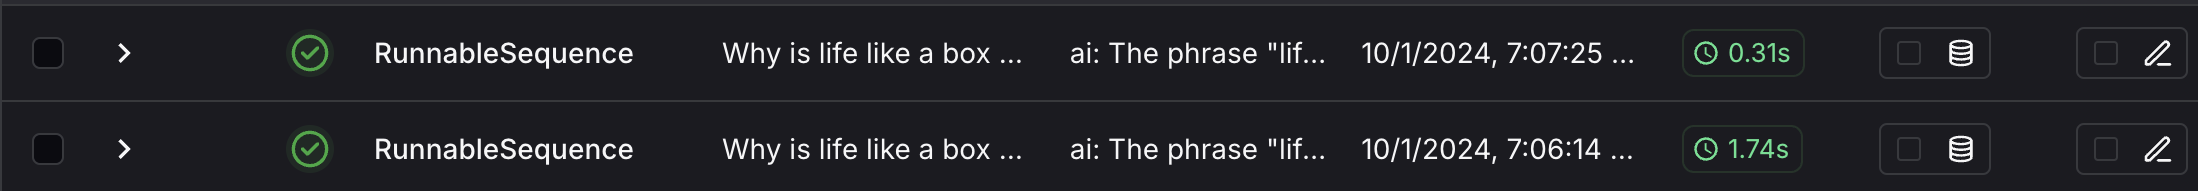